# 🔐 Styling

In [1]:
%%HTML
<style>
body {
    --vscode-font-family : 'Nasalization';
}

.dataframe {
    font-family : 'Futura';
    # font-family : 'Century Gothic';
    border : 2px solid #252422;
    border-radius : 5px;
    overflow : hidden;
}

.dataframe tr th {
    text-align : center;
}

.dataframe td {
    paddign : 10px;
    text-align : left;
}

.dataframe tr:hover{
    background-color : #ef233c;
}

</style>

# 🛳️ Importation

In [2]:
import calendar
import datetime as dt

import psycopg2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# 🎯 Main

## 📍 Collect data

In [3]:
# Create database connection

conn = ''

try :
    conn = psycopg2.connect(
        host = "localhost",
        port = "5432",
        user = "postgres",
        password = "postgres",
        dbname = "BudgetManagement"
    )    

except Exception as e: 
    print(e)

# Connect to Database and get informations
cursor = conn.cursor()

In [4]:
query = '''
SELECT * FROM target
WHERE montant IS NOT NULL
'''
cursor.execute(query)

colnames = [col.name for col in cursor.description]
rows = cursor.fetchall()

target = pd.DataFrame(columns=colnames, data=rows)
target

,id_categorie,cat_id_categorie,name_categorie,montant
0,1,NaN,Courses,100.00000
1,60,5.0,Streaming,14.00000
2,64,6.0,Carburant,150.00000
3,66,6.0,Assurance véhicule,130.00000
4,69,6.0,Autoroute,25.00000
5,77,7.0,Loyer,390.00000
6,87,9.0,Restauration,100.00000
7,88,9.0,Cantine,100.00000
8,97,10.0,Bancaire,130.00000
9,110,16.0,Don,10.00000


In [5]:
query = 'SELECT * FROM vue_Flux'
cursor.execute(query)

colnames = [col.name for col in cursor.description]
rows = cursor.fetchall()

data = pd.DataFrame(columns=colnames, data=rows)
data.head()

,ID Flux,Période,Type de flux,Fixes,Catégorie,Sous-catégorie,Date,Montant,Tags,Description
0,1,Entreprise,Sortie,Variable,Epargne,Livret A,2024-09-02,350.00000,#Epargne,Epargne août et réserve
1,2,Entreprise,Sortie,Variable,Divertissement,Brasserie,2024-09-02,9.00000,#Soirée,Soirée inté ENSIMAG
2,3,Entreprise,Entrée,Fixe,Emploi,Salaire,2024-09-02,1329.00000,#Salaire,Salaire août
3,4,Entreprise,Sortie,Fixe,Logement,Loyer,2024-09-02,390.00000,#Loyer,Loyer septembre 2024
4,5,Entreprise,Sortie,Exceptionnel,Impôts,Impôts,2024-09-03,103.00000,#Ecole,CVEC pour IUT


## 📍 Process

In [6]:
target = target.iloc[:, -2:]
target['montant'] = target['montant'].astype('float')

In [7]:
data['Date'] = pd.to_datetime(data['Date'])
data['Montant'] = data['Montant'].astype('float')

## 📍 Calendar

In [8]:
def get_month_end_date(date) :
    date = pd.to_datetime(date)
    month_end_day = calendar.monthrange(date.year, date.month)[1]
    month_end = date.replace(day=month_end_day)
    return month_end

In [9]:
dim_calendar_start = data.Date.min()
dim_calendar_start = dim_calendar_start.replace(month=1, day=1)

dim_calendar_end = data.Date.max()
dim_calendar_end = dim_calendar_end.replace(month=12, day=31)

dim_calendar = pd.date_range(start=dim_calendar_start, end=dim_calendar_end)
dim_calendar = pd.DataFrame(dim_calendar, columns=['Date'])

# Add features
dim_calendar['Annee'] = dim_calendar['Date'].dt.year
dim_calendar['Month'] = dim_calendar['Date'].dt.month
dim_calendar['Month Name'] = dim_calendar['Date'].dt.month_name()
dim_calendar['Week'] = dim_calendar['Date'].dt.isocalendar().week.astype('int32')

dim_calendar['Date'] = dim_calendar['Date']
dim_calendar['Annee'] = dim_calendar['Annee'].astype('str')
dim_calendar['Month'] = dim_calendar['Month'].astype('str').str.zfill(2)
dim_calendar['Week'] = dim_calendar['Week'].astype('str').str.zfill(2)

dim_calendar

,Date,Annee,Month,Month Name,Week
0,2024-01-01,2024,01,January,01
1,2024-01-02,2024,01,January,01
2,2024-01-03,2024,01,January,01
3,2024-01-04,2024,01,January,01
4,2024-01-05,2024,01,January,01
...,...,...,...,...,...
726,2025-12-27,2025,12,December,52
727,2025-12-28,2025,12,December,52
728,2025-12-29,2025,12,December,01
729,2025-12-30,2025,12,December,01


# 🎭 Visualisation

## 📋 Besoins

- Dimensions :
    - ✅ Temps
    - Catégorie
    - Sous-Catégorie

- Mesures :
    - ✅ Entrée
    - ✅ Sortie
    - ✅ Disponible
    - ✅ Entrée en Epargne
    - ✅ Sortie en Epargne
    - ✅ Epargné

- Visuels : 
    - 📜 Page N°1 :
        - Vignettes des mesures
        - ✅ Sortie par Catégorie
        - ❌ Graphique en camembert pour les top 5 dépenses
        - ✅ Dépenses sur le temps avec une hue = 'Période'

    - 📜 Page N°2 :
        - ✅ Sortie par Catégorie, Sous-Catégorie
        - ✅ Tableau des dépenses
    
    - 📜 Page N°3 :
        - ✅ Entrée par temps
        - ✅ Sortie par temps

    - 📜 Page N°4 :
        - Visuels target

## 🎨 Couleurs

In [10]:
custom_colors_palette_dict = {
    'Light' : [
        '#F72585',
        '#7209B7',
        '#3A0CA3',
        '#4361EE',
        '#4CC9F0',
    ],

    'Tropical' : [
        '#390099',
        '#9E0059',
        '#FF0054',
        '#FF5400',
        '#FFBD00',
    ],

    'Ireland' : [
        '#ff9f1c',
        '#ffbf69',
        '#ffffff',
        '#cbf3f0',
        '#2ec4b6',
    ],
        
    'Purple' : [
        '#5465ff',
        '#788bff',
        '#9bb1ff',
        '#bfd7ff',
        '#e2fdff',
    ],
}

In [11]:
custom_colors_palette = [
    '#F72585',
    '#7209B7',
    '#3A0CA3',
    '#4361EE',
    '#4CC9F0',

    '#390099',
    '#9E0059',
    '#FF0054',
    '#FF5400',
    '#FFBD00',

    '#ff9f1c',
    '#ffbf69',
    '#ffffff',
    '#cbf3f0',
    '#2ec4b6',

    '#22162b',
    '#451f55',
    '#724e91',
    '#e54f6d',
    '#f8c630',

    '#5465ff',
    '#788bff',
    '#9bb1ff',
    '#bfd7ff',
    '#bfd7ff',
]

custom_colors_palette = [
    '#FF4D6D',
    '#F72585',
    '#7209B7',
    '#7678ED',
    '#4361EE',
    '#4CC9F0',
    '#2EC4B6',
    '#52B788',
    '#FFBD00',
    '#FF5400',
    '#EF233C',
    '#D58936',
]

In [12]:
custom_colors_palette_display = sns.palettes.color_palette(custom_colors_palette)
custom_colors_palette_display

[(1.0, 0.30196078431372547, 0.42745098039215684),
 (0.9686274509803922, 0.1450980392156863, 0.5215686274509804),
 (0.4470588235294118, 0.03529411764705882, 0.7176470588235294),
 (0.4627450980392157, 0.47058823529411764, 0.9294117647058824),
 (0.2627450980392157, 0.3803921568627451, 0.9333333333333333),
 (0.2980392156862745, 0.788235294117647, 0.9411764705882353),
 (0.1803921568627451, 0.7686274509803922, 0.7137254901960784),
 (0.3215686274509804, 0.7176470588235294, 0.5333333333333333),
 (1.0, 0.7411764705882353, 0.0),
 (1.0, 0.32941176470588235, 0.0),
 (0.9372549019607843, 0.13725490196078433, 0.23529411764705882),
 (0.8352941176470589, 0.5372549019607843, 0.21176470588235294)]

## 📐 Mesures

In [13]:
def calculate_entree(df) :
    result = df[df['Type de flux'] == 'Entrée']['Montant'].sum()
    return result

def calculate_sortie(df) :
    result = df[df['Type de flux'] == 'Sortie']['Montant'].sum()
    return result

def calculate_disponible(df) :
    return calculate_entree(df) - calculate_sortie(df)

def calculate_entree_depuis_epargne(df) :
    result = df[
            (df['Type de flux'] == 'Entrée')
        &   (df['Catégorie'] == 'Epargne')
    ]['Montant'].sum()
    return result

def calculate_sortie_en_epargne(df) :
    result = df[
            (df['Type de flux'] == 'Sortie')
        &   (df['Catégorie'] == 'Epargne')
    ]['Montant'].sum()
    return result

def calculate_epargne(df) :
    return calculate_entree_depuis_epargne(df) - calculate_sortie_en_epargne(df)

## 📕 Fonctions

### 📝 plot_flux_sur_le_temps

In [14]:
def plot_flux_sur_le_temps(donnees) :
    data_entree_sortie = donnees.copy()

    # Grouper les valeurs
    data_entree_sortie = data_entree_sortie.groupby(['Date', 'Période','Type de flux'])['Montant'].sum().reset_index()
    data_entree_sortie = data_entree_sortie.sort_values('Date')

    month_days_list = dim_calendar[
            (dim_calendar['Date'] >= data_entree_sortie['Date'].min())
        &   (dim_calendar['Date'] <= get_month_end_date(donnees['Date'].min()))
    ]['Date']

    # Gestion des valeurs nulles
    data_entree_sortie = data_entree_sortie.merge(month_days_list, how='right')
    data_entree_sortie['Période'] = data_entree_sortie['Période'].fillna('---')
    data_entree_sortie['Type de flux'] = data_entree_sortie['Type de flux'].fillna('---')
    data_entree_sortie['Montant'] = data_entree_sortie['Montant'].fillna(0)

    # Ajout de couleurs
    dict_periode_couleur = {
        'Entreprise' : '#390099',
        'Ecole' : '#9E0059',
        'Vacances' : '#FF0054',
        '---' : '---'
    }

    dict_periode_couleur = dict(zip(data_entree_sortie['Période'].unique(), custom_colors_palette))
    data_entree_sortie['Couleur'] = data_entree_sortie['Période'].map(dict_periode_couleur)


    entree_data = data_entree_sortie[data_entree_sortie['Type de flux'] == 'Entrée']
    sortie_data = data_entree_sortie[data_entree_sortie['Type de flux'] == 'Sortie']

    fig, ax = plt.subplots(figsize=(30, 5))

    plt.bar(sortie_data['Date'], sortie_data['Montant'], color=sortie_data['Couleur'])
    plt.scatter(entree_data['Date'], entree_data['Montant'], label='Entrée', color='#4CC9F0')

    ax.set_xticks(data_entree_sortie['Date'], data_entree_sortie['Date'].dt.date, rotation=90)

    handles = []
    for key, color in dict_periode_couleur.items() :
        patch = mpatches.Patch(label=key, color=color)
        handles.append(patch)

    plt.title('Entrée et Sortie sur le mois')
    plt.legend(handles=handles)
    plt.show()

In [15]:
custom_colors_palette_dict['Tropical']

['#390099', '#9E0059', '#FF0054', '#FF5400', '#FFBD00']

### 📝 plot_depenses_par_categorie

In [16]:
def plot_depenses_par_categorie(donnees, sort_by_montant = False) : 
    sortie_categorie = donnees.copy()
    sortie_categorie = sortie_categorie[sortie_categorie['Type de flux'] == 'Sortie']
    sortie_categorie = sortie_categorie.groupby(['Catégorie'])['Montant'].sum().reset_index()
    
    sortie_categorie = sortie_categorie.sort_values('Catégorie')

    if sort_by_montant == True :
        sortie_categorie = sortie_categorie.sort_values('Montant', ascending=False)
        

    dict_couleur = dict(zip(sortie_categorie['Catégorie'].unique(), custom_colors_palette))
    sortie_categorie['Couleur'] = sortie_categorie['Catégorie'].map(dict_couleur)



    fig, ax = plt.subplots(figsize=(30, 5))

    bar = ax.bar(sortie_categorie['Catégorie'], sortie_categorie['Montant'], color=sortie_categorie['Couleur'])
    ax.bar_label(bar, label_type='edge', color='#000000', padding=1.2)

    plt.title('Dépenses par Catégorie')
    plt.yticks(np.arange(0, sortie_categorie['Montant'].max() * 1.2, 100))
    plt.show()

### 📝 plot_depenses_par_ss_categorie

In [17]:
def plot_depenses_par_ss_categorie(donnees, categories, sort_by_montant = False) :
    sortie_ss_categorie = donnees.copy()

    if len(categories) == 0 :
        categories = donnees['Catégorie'].unique()

    
    # Grouper par Catégorie
    sortie_categorie = donnees.copy()
    sortie_categorie = sortie_categorie[sortie_categorie['Type de flux'] == 'Sortie']
    sortie_categorie = sortie_categorie.groupby(['Catégorie'])['Montant'].sum().reset_index()
    
    sortie_categorie = sortie_categorie.sort_values('Catégorie')
    
    if sort_by_montant == True :
        sortie_categorie = sortie_categorie.sort_values('Montant', ascending=False)
    
    sortie_categorie = sortie_categorie.reset_index()
    sortie_categorie['index'] = sortie_categorie.index
    sortie_categorie = sortie_categorie.drop('Montant', axis=1)

    dict_couleur = dict(zip(sortie_categorie['Catégorie'].unique(), custom_colors_palette))


    # Grouper par Sous-catégorie

    sortie_ss_categorie = sortie_ss_categorie[
            (sortie_ss_categorie['Type de flux'] == 'Sortie')
        &   (sortie_ss_categorie['Catégorie'].isin(categories))
    ]
    sortie_ss_categorie = sortie_ss_categorie.groupby(['Catégorie', 'Sous-catégorie'])['Montant'].sum().reset_index()

    sortie_ss_categorie = sortie_ss_categorie.sort_values(['Catégorie', 'Sous-catégorie'])

    if sort_by_montant == True :
        sortie_ss_categorie = sortie_ss_categorie.merge(sortie_categorie)
        sortie_ss_categorie = sortie_ss_categorie.sort_values(['index', 'Sous-catégorie'])
        sortie_ss_categorie = sortie_ss_categorie.sort_values(['index', 'Montant'], ascending=[True, False])

    sortie_ss_categorie['Couleur'] = sortie_ss_categorie['Catégorie'].map(dict_couleur)

    fig, ax = plt.subplots(figsize=(30, 5))

    bar = ax.bar(sortie_ss_categorie['Sous-catégorie'], sortie_ss_categorie['Montant'], color=sortie_ss_categorie['Couleur'])
    ax.bar_label(bar, label_type='edge', color='#000000', padding=1.2)

    handles = []
    for key, color in dict_couleur.items() :
        patch = mpatches.Patch(label=key, color=color)
        handles.append(patch)

    plt.xticks(rotation=90)

    plt.title('Dépenses par Sous-Catégorie')
    plt.legend(handles = handles)
    plt.show()

### 📝 plot_entree_sur_temps

In [18]:
def plot_entree_sur_temps(donnees, period, month_end) :
    data = donnees.copy()
    data = data[data['Type de flux'] == 'Entrée']

    data_columns = ['Date', 'Type de flux', 'Période', 'Fixes', 'Catégorie', 'Sous-catégorie', 'Montant']
    data_columns = ['Date', 'Montant']
    data = data[data_columns]

    if month_end is True :
        date_max = get_month_end_date(donnees['Date'].min())
    else :
        date_max = donnees['Date'].max()
        
    month_days_list = dim_calendar[
            (dim_calendar['Date'] >= donnees['Date'].min())
        &   (dim_calendar['Date'] <= date_max)
    ]['Date']


    data = data.merge(month_days_list, how='right')
    data = data.merge(dim_calendar, how='inner')

    data['Week_Format'] = 'W' + data['Week']
    data['Year-Month'] = data['Annee'] + '-' + data['Month']
    data['Year-Week'] = data['Annee'] + '-' + data['Week_Format']

    dict_groupby_columns = {
        'year' : 'Annee',
        'month' : 'Year-Month',
        'week' : 'Year-Week',
    }

    data = data.groupby(dict_groupby_columns[period])['Montant'].sum()
    data = data.reset_index()

    fig, ax = plt.subplots(figsize=(30, 5))

    bar = ax.bar(data[dict_groupby_columns[period]], data['Montant'], color='#4361EE')
    ax.bar_label(bar, label_type='edge', color='#000000', padding=1.5)

    plt.title('Entrée sur le temps')
    plt.show()

### 📝 plot_depenses_sur_temps

In [19]:
def plot_depenses_sur_temps(donnees, period, month_end) :
    data = donnees.copy()
    data = data[data['Type de flux'] == 'Sortie']

    data_columns = ['Date', 'Type de flux', 'Période', 'Fixes', 'Catégorie', 'Sous-catégorie', 'Montant']
    data_columns = ['Date', 'Montant']
    data = data[data_columns]

    if month_end is True :
        date_max = get_month_end_date(donnees['Date'].min())
    else :
        date_max = donnees['Date'].max()
        
    month_days_list = dim_calendar[
            (dim_calendar['Date'] >= donnees['Date'].min())
        &   (dim_calendar['Date'] <= date_max)
    ]['Date']


    data = data.merge(month_days_list, how='right')
    data = data.merge(dim_calendar, how='inner')

    data['Week_Format'] = 'W' + data['Week']
    data['Year-Month'] = data['Annee'] + '-' + data['Month']
    data['Year-Week'] = data['Annee'] + '-' + data['Week_Format']

    dict_groupby_columns = {
        'year' : 'Annee',
        'month' : 'Year-Month',
        'week' : 'Year-Week',
    }

    data = data.groupby(dict_groupby_columns[period])['Montant'].sum()
    data = data.reset_index()

    fig, ax = plt.subplots(figsize=(30, 5))

    bar = ax.bar(data[dict_groupby_columns[period]], data['Montant'], color='#FF4D6D')
    ax.bar_label(bar, label_type='edge', color='#000000', padding=1.5)

    plt.title('Dépenses sur le temps')
    plt.show()

### 📝 plot_target_comparaison

In [20]:
def plot_target_comparaison(donnees) :
    target_comparaison = target.copy()
    target_comparaison


    depenses_reel_categorie = donnees.groupby(['Catégorie'])['Montant'].sum().reset_index()
    depenses_reel_categorie = depenses_reel_categorie.rename(columns={'Catégorie' : 'name_categorie'})

    depenses_reel_ss_categorie = donnees.groupby(['Sous-catégorie'])['Montant'].sum().reset_index()
    depenses_reel_ss_categorie = depenses_reel_ss_categorie.rename(columns={'Sous-catégorie' : 'name_categorie'})

    depenses_reel = pd.concat([depenses_reel_categorie, depenses_reel_ss_categorie])

    target_comparaison = target_comparaison.merge(depenses_reel, how='left').fillna(0)
    target_comparaison = target_comparaison.rename(columns={
        'name_categorie' : 'Catégorie',
        'montant' : 'Target',
        'Montant' : 'Réel',
    })

    target_comparaison['target_reached'] = np.where(target_comparaison['Réel'] >= target_comparaison['Target'], 'YES', 'NO')
    target_comparaison['difference'] = target_comparaison['Target'] - target_comparaison['Réel']

    target_comparaison['below'] = np.where(target_comparaison['target_reached'] == 'YES', target_comparaison['Target'], target_comparaison['Réel'])
    target_comparaison['above'] = np.abs(target_comparaison['difference'])

    target_comparaison['above_bar_color'] = np.where(target_comparaison['target_reached'] == 'YES', '#f72585', '#f8c630')
    target_comparaison = target_comparaison.sort_values('Target', ascending=False)

    fig, ax = plt.subplots(figsize=(30, 5))

    # Line plot
    ax.plot(target_comparaison['Catégorie'], target_comparaison['Target'], linestyle='--', marker='o', color='#000000', label='Target')

    # Above bar
    p_above_bar = ax.bar(target_comparaison['Catégorie'], target_comparaison['above'], bottom=target_comparaison['below'], color=target_comparaison['above_bar_color'])
    ax.bar_label(p_above_bar, label_type='center', color='#FFFFFF')

    # Below
    p_below_bar = ax.bar(target_comparaison['Catégorie'], target_comparaison['below'], color='#4361EE')
    ax.bar_label(p_below_bar, label_type='center', color='#FFFFFF')

    # Plot settings
    plt.xticks(rotation=90, size=12)
    ax.set(yticks=np.arange(0, target_comparaison['Target'].max() * 1.2, 100))
    ax.grid(axis='y', color='#000000')
    ax.set_axisbelow(True)

    # Legend
    blue_bar = mpatches.Patch(color='#4361EE', label='Dépensé')
    pink_bar = mpatches.Patch(color='#F72585', label='Surplus')
    yellow_bar = mpatches.Patch(color='#f8c630', label='Restant')

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles + [blue_bar, pink_bar, yellow_bar])

    plt.title('Analyses des dépenses fixes')
    plt.show()

## 📍 Filter data

In [21]:
# Relative dates from today
today = dt.datetime.today()
today = dt.datetime.combine(dt.datetime.today().date(), dt.time.min)

week_start = today - dt.timedelta(today.weekday())
week_end = week_start + dt.timedelta(days=6)

month_start = today.replace(day=1)
month_end = get_month_end_date(month_start)

# Specific dates
custom_start = dt.datetime(2025, 6, 1).date()
custom_end = dt.datetime(2025, 6, 15).date()

custom_start = pd.to_datetime('2025-11-01')
custom_end = pd.to_datetime('2025-11-30')

custom_month_end = get_month_end_date(custom_start)

In [22]:
page_date_start = month_start
page_date_end = month_end

## 📜 Page N°1

In [23]:
# Définitions des filtres
page_1_filter_periode = [
    'Ecole',
    'Entreprise',
    'Vacances',
]

page_1_filter_type_flux = [
    'Entrée',
    'Neutre',
    'Réparation',
    'Sortie',
]

page_1_filter_fixes = [
    'Exceptionnel',
    'Fixe',
    'Variable',
]

page_1_filter_period_start = page_date_start
page_1_filter_period_end = page_date_end

page_1_filter_categorie = [

]
page_1_filter_ss_categorie = [

]

if len(page_1_filter_categorie) == 0 :
    page_1_filter_categorie = data['Catégorie'].unique()
if len(page_1_filter_ss_categorie) == 0 :
    page_1_filter_ss_categorie = data['Sous-catégorie'].unique()

# Extracttion de données filtrées
page_1_data = data.copy()
page_1_data = page_1_data[
        (page_1_data['Période'].isin(page_1_filter_periode))
    &   (page_1_data['Type de flux'].isin(page_1_filter_type_flux))
    &   (page_1_data['Fixes'].isin(page_1_filter_fixes))
    &   (page_1_data['Date'] >= page_1_filter_period_start)
    &   (page_1_data['Date'] <= page_1_filter_period_end)
    &   (page_1_data['Catégorie'].isin(page_1_filter_categorie))
    &   (page_1_data['Sous-catégorie'].isin(page_1_filter_ss_categorie))
]

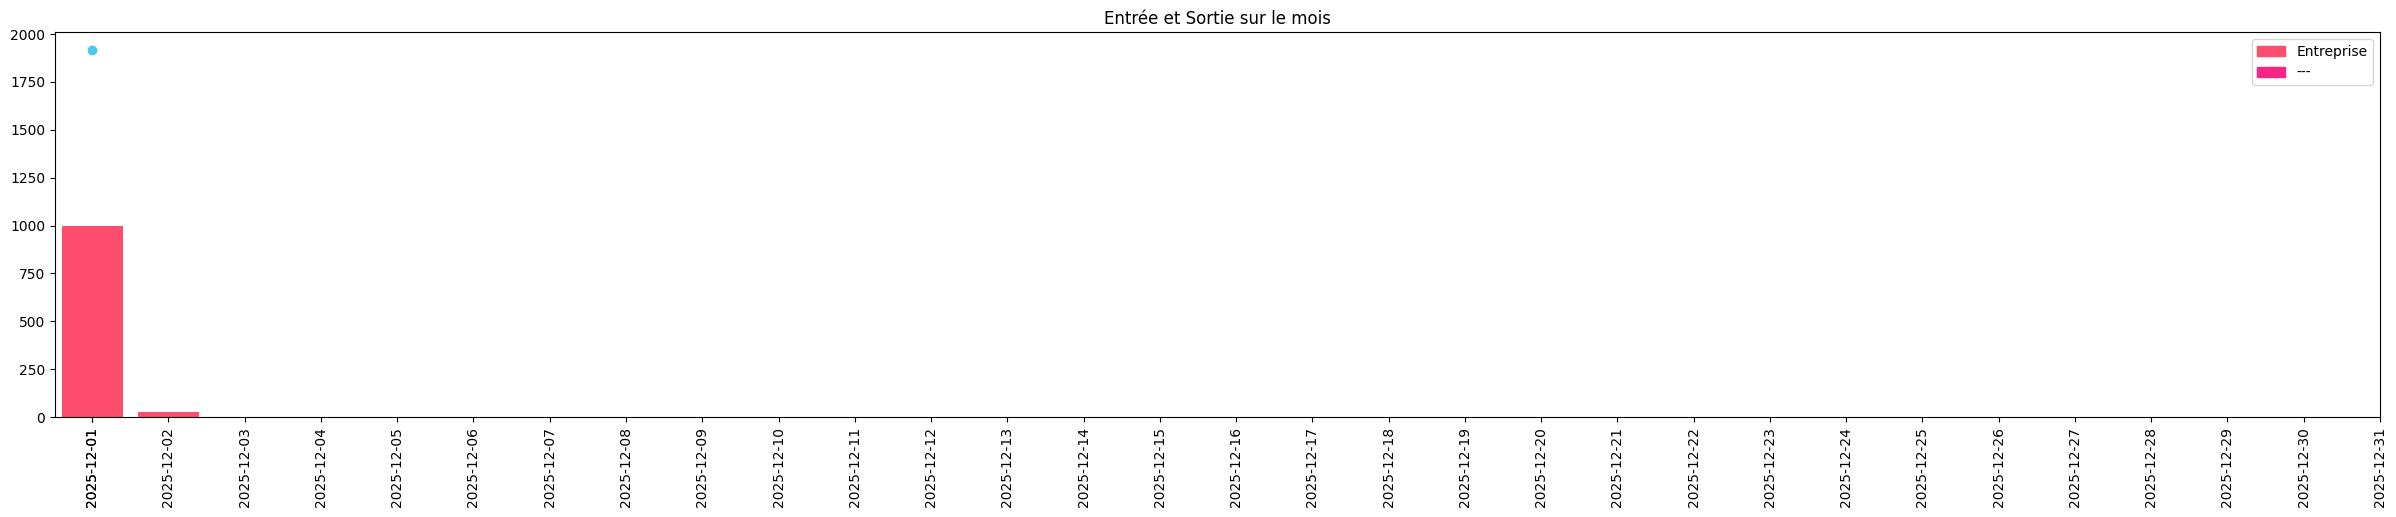

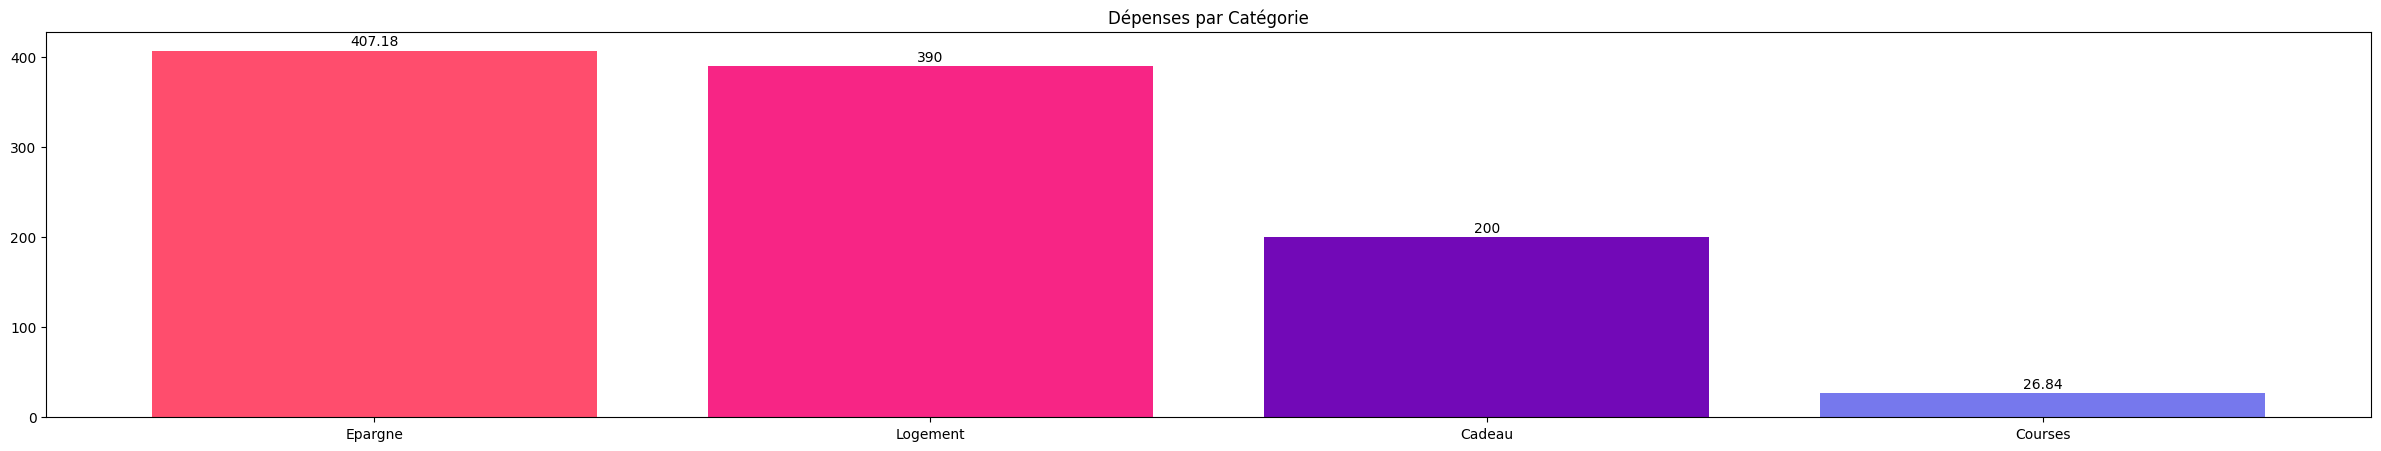

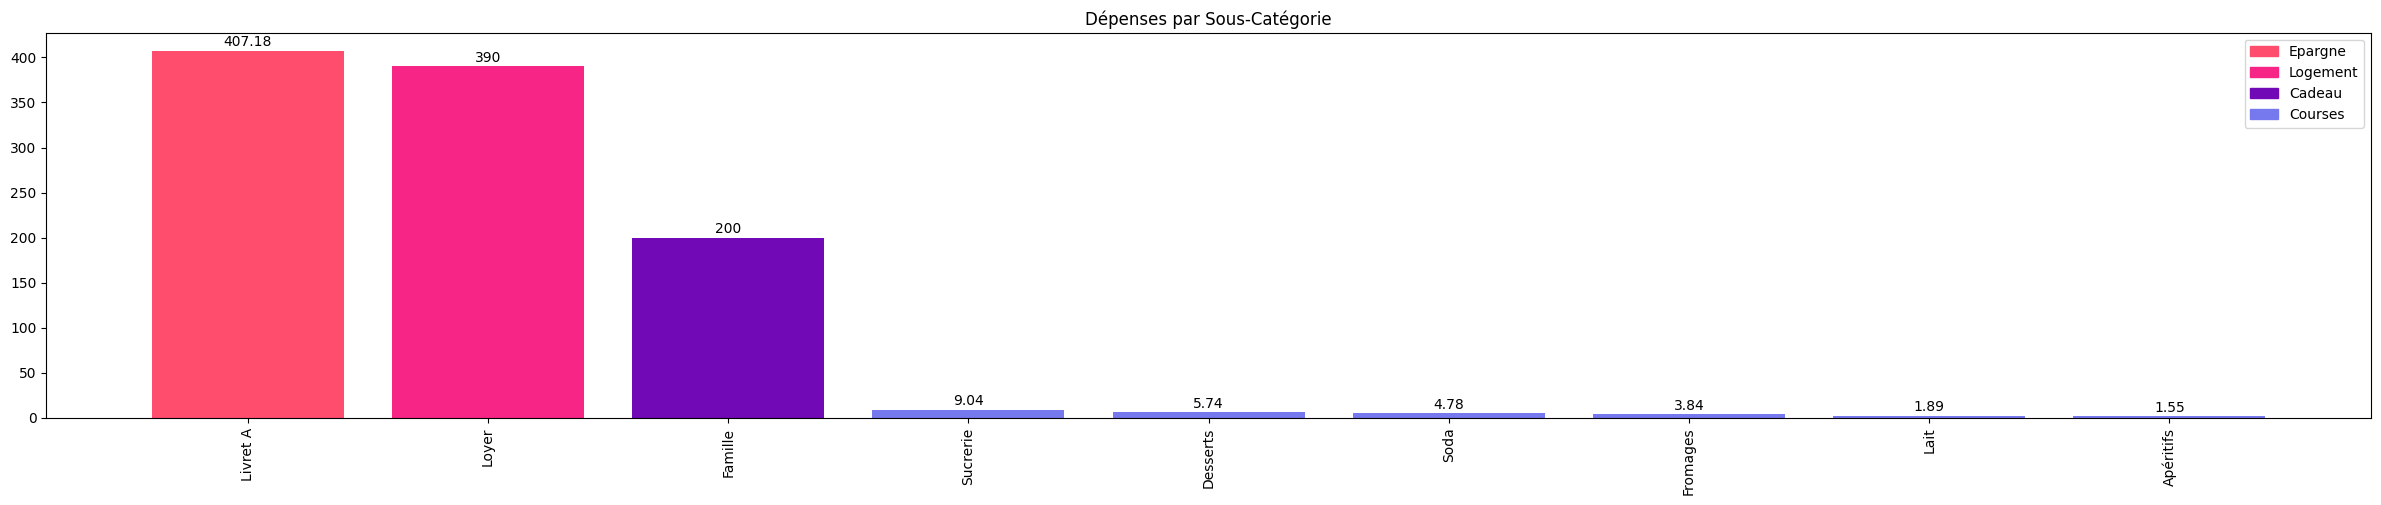

In [24]:
sort_by_montant = True
plot_flux_sur_le_temps(page_1_data)
plot_depenses_par_categorie(page_1_data, sort_by_montant)

liste_ss_cat = [
    # 'Transports',
    # 'Divertissement',
    # 'Courses',
    # 'Abonnement',
]
plot_depenses_par_ss_categorie(page_1_data, liste_ss_cat, sort_by_montant)

## 📜 Page N°2

In [25]:
# Définitions des filtres
page_2_filter_periode = [
    'Ecole',
    'Entreprise',
    'Vacances',
]

page_2_filter_type_flux = [
    'Entrée',
    'Neutre',
    'Réparation',
    'Sortie',
]

page_2_filter_fixes = [
    'Exceptionnel',
    'Fixe',
    'Variable',
]

page_2_filter_period_start = page_date_start
page_2_filter_period_end = page_date_end

page_2_filter_categorie = [
    # 'Autre'

]
page_2_filter_ss_categorie = [

]

if len(page_2_filter_categorie) == 0 :
    page_2_filter_categorie = data['Catégorie'].unique()
if len(page_2_filter_ss_categorie) == 0 :
    page_2_filter_ss_categorie = data['Sous-catégorie'].unique()

# Extracttion de données filtrées
page_2_data = data.copy()
page_2_data = page_2_data[
        (page_2_data['Période'].isin(page_2_filter_periode))
    &   (page_2_data['Type de flux'].isin(page_2_filter_type_flux))
    &   (page_2_data['Fixes'].isin(page_2_filter_fixes))
    &   (page_2_data['Date'] >= page_2_filter_period_start)
    &   (page_2_data['Date'] <= page_2_filter_period_end)
    &   (page_2_data['Catégorie'].isin(page_2_filter_categorie))
    &   (page_2_data['Sous-catégorie'].isin(page_2_filter_ss_categorie))
]

page_2_data['Entrée'] = np.where(page_2_data['Type de flux'] == 'Entrée', page_2_data['Montant'], '---')
page_2_data['Sortie'] = np.where(page_2_data['Type de flux'] == 'Sortie', page_2_data['Montant'], '---')

page_2_columns = ['ID Flux', 'Date', 'Période', 'Type de flux', 'Fixes', 'Catégorie', 'Sous-catégorie', 'Entrée', 'Sortie', 'Description', 'Tags']

page_2_data[page_2_columns]

,ID Flux,Date,Période,Type de flux,Fixes,Catégorie,Sous-catégorie,Entrée,Sortie,Description,Tags
1259,1308,2025-12-01,Entreprise,Entrée,Variable,Emploi,Salaire,1913.25,---,Salaire mois de Novembre,#salaire
1260,1309,2025-12-01,Entreprise,Sortie,Variable,Epargne,Livret A,---,407.18,Epargne début du mois,#epargne
1261,1310,2025-12-01,Entreprise,Sortie,Fixe,Cadeau,Famille,---,200.0,Cadeau pour papa et maman,#parents
1262,1311,2025-12-01,Entreprise,Sortie,Fixe,Logement,Loyer,---,390.0,Loyer decembre 2025,#loyer
1263,1312,2025-12-02,Entreprise,Sortie,Variable,Courses,Soda,---,2.39,Courses carrefour début du mois,#coca
1264,1313,2025-12-02,Entreprise,Sortie,Variable,Courses,Soda,---,2.39,Courses carrefour début du mois,#coca
1265,1314,2025-12-02,Entreprise,Sortie,Variable,Courses,Desserts,---,1.75,Courses carrefour début du mois,#danette
1266,1315,2025-12-02,Entreprise,Sortie,Variable,Courses,Desserts,---,3.99,Courses carrefour début du mois,#yaourts
1267,1316,2025-12-02,Entreprise,Sortie,Variable,Courses,Sucrerie,---,1.75,Courses carrefour début du mois,#loops
1268,1317,2025-12-02,Entreprise,Sortie,Variable,Courses,Sucrerie,---,1.99,Courses carrefour début du mois,#biscuits


In [26]:
flux_summary = [
    {'Description' : 'Entrée depuis epargne', 'Montant' : calculate_entree_depuis_epargne(page_2_data)},
    {'Description' : 'Sortie en epargne', 'Montant' : calculate_sortie_en_epargne(page_2_data)},
    {'Description' : 'Entree', 'Montant' : calculate_entree(page_2_data)},
    {'Description' : 'Sortie', 'Montant' : calculate_sortie(page_2_data)},
    {'Description' : 'Disponible', 'Montant' : calculate_disponible(page_2_data)},
]

flux_summary = pd.DataFrame(flux_summary)
flux_summary['Montant'] = flux_summary['Montant'].round(6)
flux_summary

,Description,Montant
0,Entrée depuis epargne,0.00
1,Sortie en epargne,407.18
2,Entree,1913.25
3,Sortie,1024.02
4,Disponible,889.23


## 📜 Page N°3

In [27]:
# Définitions des filtres
page_3_filter_periode = [
    'Ecole',
    'Entreprise',
    'Vacances',
]

page_3_filter_type_flux = [
    'Entrée',
    'Neutre',
    'Réparation',
    'Sortie',
]

page_3_filter_fixes = [
    'Exceptionnel',
    'Fixe',
    'Variable',
]

page_3_filter_period_start = page_date_start
page_3_filter_period_end = page_date_end

page_3_filter_categorie = [

]
page_3_filter_ss_categorie = [

]

if len(page_3_filter_categorie) == 0 :
    page_3_filter_categorie = data['Catégorie'].unique()
if len(page_3_filter_ss_categorie) == 0 :
    page_3_filter_ss_categorie = data['Sous-catégorie'].unique()

# Extracttion de données filtrées
page_3_data = data.copy()
page_3_data = page_3_data[
        (page_3_data['Période'].isin(page_3_filter_periode))
    &   (page_3_data['Type de flux'].isin(page_3_filter_type_flux))
    &   (page_3_data['Fixes'].isin(page_3_filter_fixes))
    &   (page_3_data['Date'] >= page_3_filter_period_start)
    &   (page_3_data['Date'] <= page_3_filter_period_end)
    &   (page_3_data['Catégorie'].isin(page_3_filter_categorie))
    &   (page_3_data['Sous-catégorie'].isin(page_3_filter_ss_categorie))
]
page_3_data

,ID Flux,Période,Type de flux,Fixes,Catégorie,Sous-catégorie,Date,Montant,Tags,Description
1259,1308,Entreprise,Entrée,Variable,Emploi,Salaire,2025-12-01,1913.25,#salaire,Salaire mois de Novembre
1260,1309,Entreprise,Sortie,Variable,Epargne,Livret A,2025-12-01,407.18,#epargne,Epargne début du mois
1261,1310,Entreprise,Sortie,Fixe,Cadeau,Famille,2025-12-01,200.00,#parents,Cadeau pour papa et maman
1262,1311,Entreprise,Sortie,Fixe,Logement,Loyer,2025-12-01,390.00,#loyer,Loyer decembre 2025
1263,1312,Entreprise,Sortie,Variable,Courses,Soda,2025-12-02,2.39,#coca,Courses carrefour début du mois
1264,1313,Entreprise,Sortie,Variable,Courses,Soda,2025-12-02,2.39,#coca,Courses carrefour début du mois
1265,1314,Entreprise,Sortie,Variable,Courses,Desserts,2025-12-02,1.75,#danette,Courses carrefour début du mois
1266,1315,Entreprise,Sortie,Variable,Courses,Desserts,2025-12-02,3.99,#yaourts,Courses carrefour début du mois
1267,1316,Entreprise,Sortie,Variable,Courses,Sucrerie,2025-12-02,1.75,#loops,Courses carrefour début du mois
1268,1317,Entreprise,Sortie,Variable,Courses,Sucrerie,2025-12-02,1.99,#biscuits,Courses carrefour début du mois


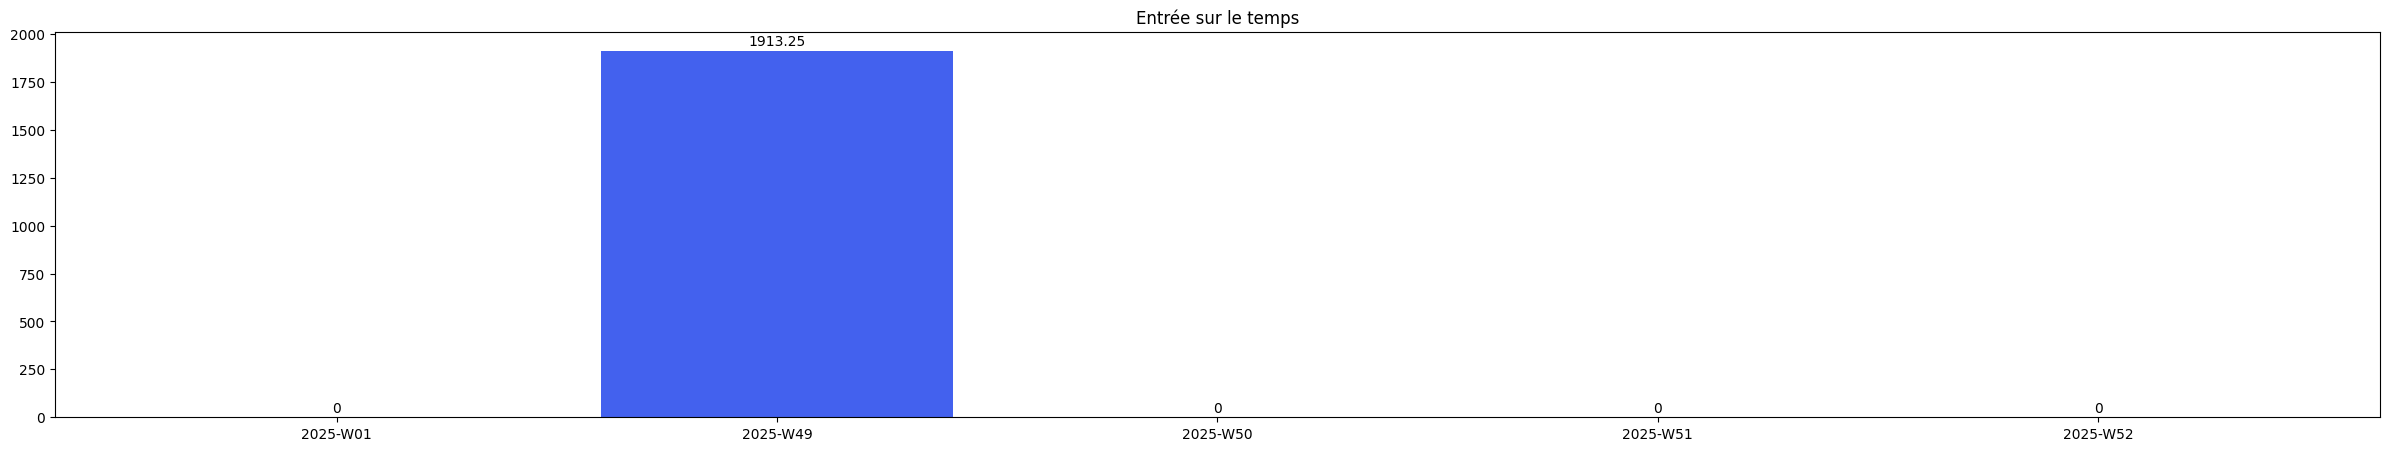

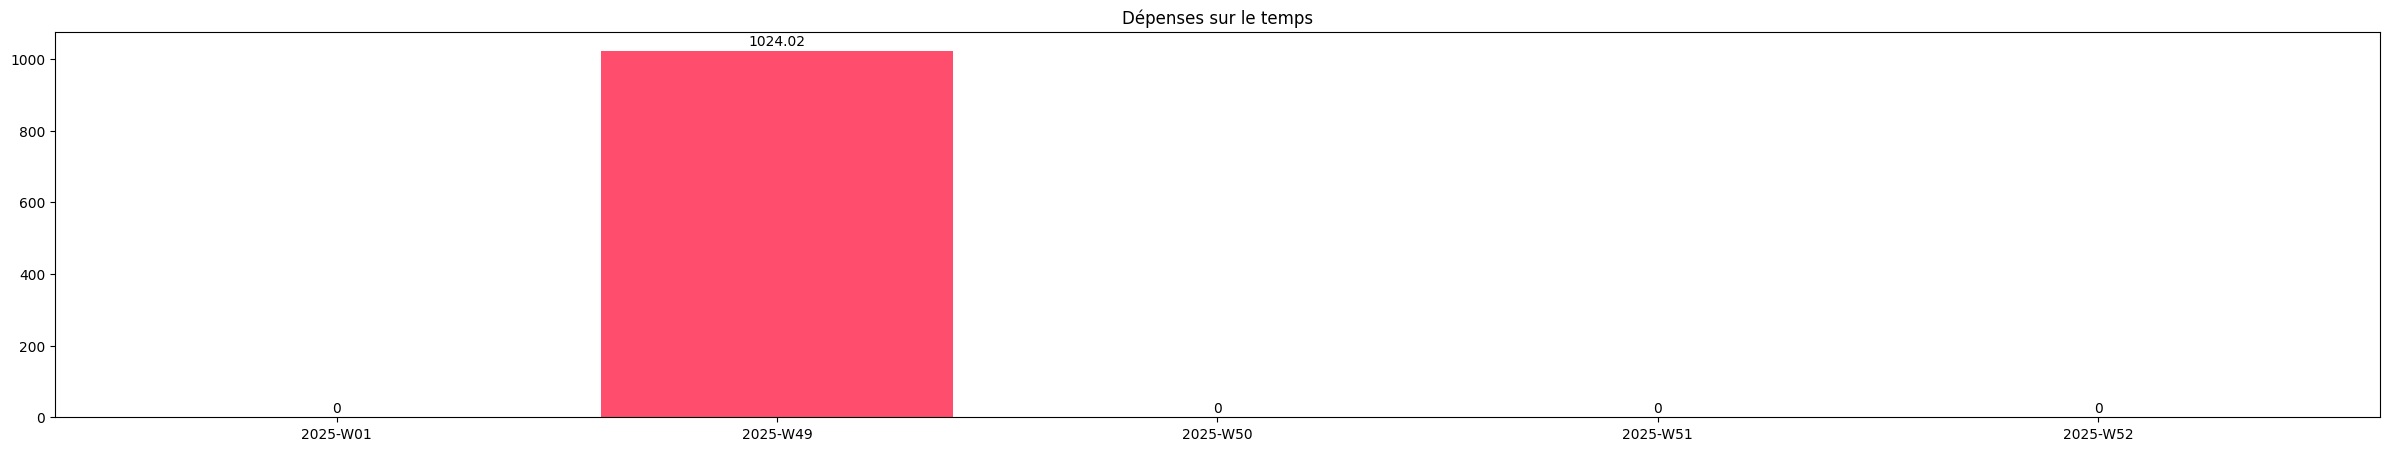

In [28]:
plot_entree_sur_temps(page_3_data, 'week', True)
plot_depenses_sur_temps(page_3_data, 'week', True)

## 📜 Page N°4

In [29]:
page_4_filter_period_start = page_date_start
page_4_filter_period_end = page_date_end


# Extracttion de données filtrées
page_4_data = data.copy()
page_4_data = page_4_data[
        (page_4_data['Date'] >= page_4_filter_period_start)
    &   (page_4_data['Date'] <= page_4_filter_period_end)
]

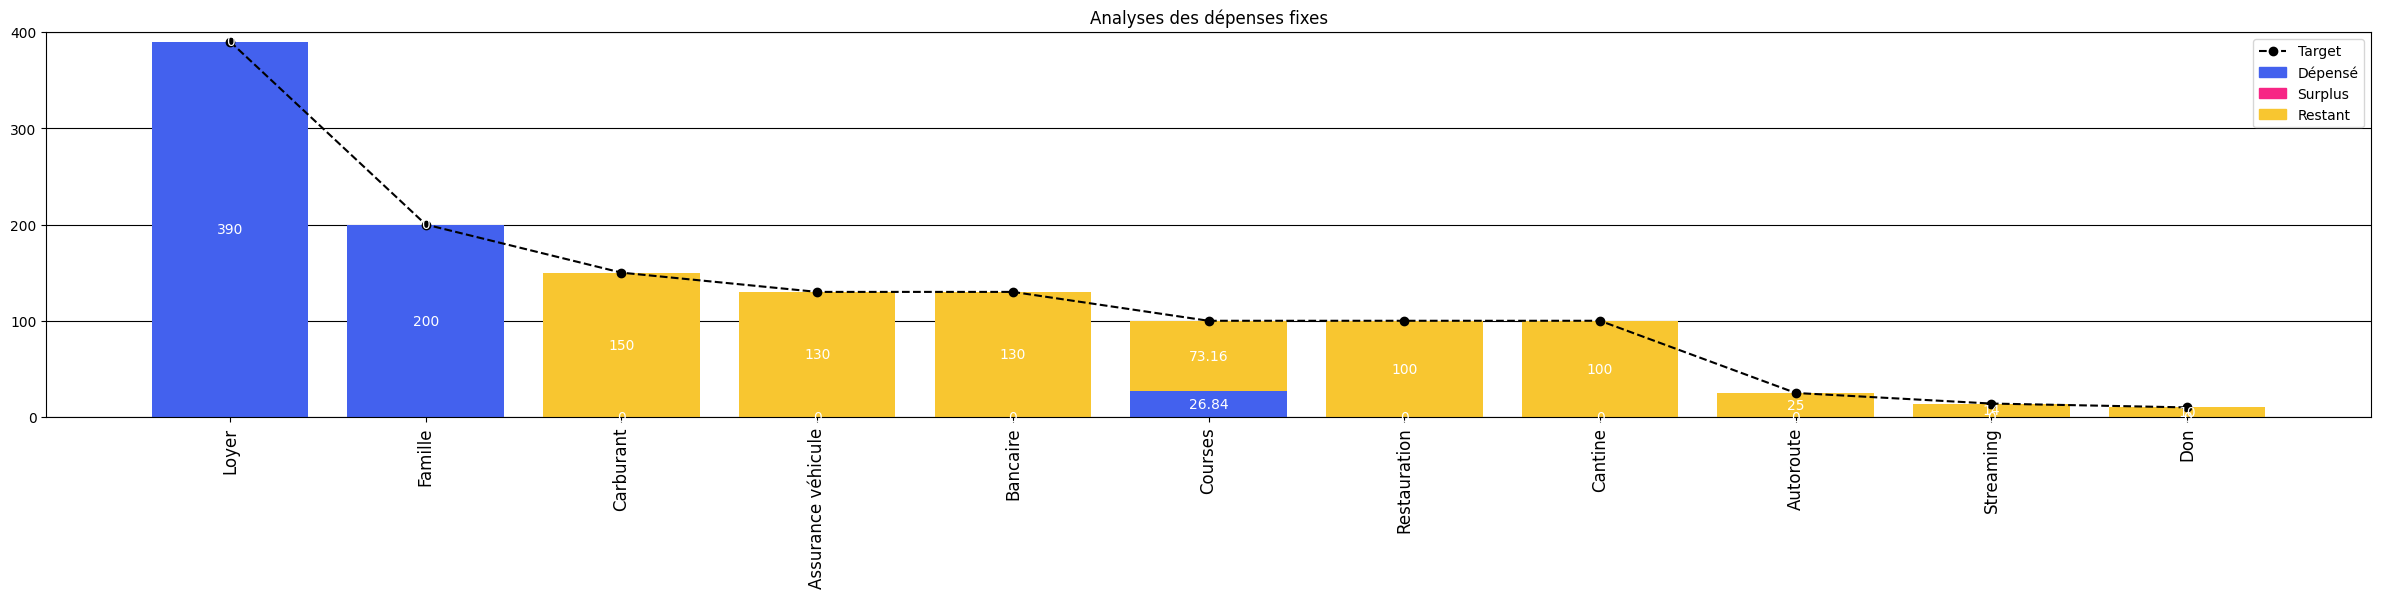

In [30]:
plot_target_comparaison(page_4_data)

# 🔮 Experiments